# 01 - Quant Research Pipeline

## Systematic Alpha Discovery Framework

**Philosophy**: Build systematic, reproducible research pipeline for discovering and validating trading signals.

### Pipeline Overview

```
Data (10 years, 100 

qassets)
    │
    ├── Train: 2016-2021 (6 years) - Feature engineering + Model training
    ├── Validation: 2022-2023 (2 years) - Hyperparameter tuning
    └── Holdout: 2024-2026 (2 years) - Final evaluation (NEVER TOUCHED)

Features (5 Categories, 60+ features)
    │
    ├── Momentum: Trend-following signals
    ├── Volatility: Risk regime indicators
    ├── Mean Reversion: Counter-trend signals
    ├── Stat Arb: Cross-sectional relationships
    └── Technical: Classic indicators

Models (Walk-Forward Validation)
    │
    ├── LightGBM: Primary model (feature importance)
    └── MLP: Advanced model (if LGBM shows edge)
```

### Data Split Clarification

From the task document: *"We want to see out-of-sample performance on at least two years worth of data"*

This means:
- Walk-forward validation on Training + Validation (2016-2023, 8 years)
- **Final holdout test**: 2024-2026 (2 years) - evaluate with FIXED model parameters
- The holdout is completely unseen during development

In [1]:
# =============================================================================
# SETUP
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

# Add src to path
import sys
sys.path.insert(0, '../src')

# Imports
from data.loader import DataLoader, DataConfig
from features.feature_store import FeatureStore, FeatureConfig

print("✅ Setup complete")

✅ Setup complete


---

# Part 1: Data Loading & Exploration

Load the 10-year daily dataset and understand its structure.

In [2]:
# =============================================================================
# LOAD DATA
# =============================================================================

# Configure data splits
config = DataConfig(
    data_dir="../../data/raw/assets",
    train_start="2016-01-01",
    train_end="2021-12-31",
    val_start="2022-01-01",
    val_end="2023-12-31",
    test_start="2024-01-01",
    test_end="2026-12-31",
)

# Load data
loader = DataLoader(config)
loader.load_all()

# Quick summary
print(f"\n📊 Dataset Summary:")
print(f"   Assets: {loader.metadata['n_assets']}")
print(f"   Days: {loader.metadata['n_days']}")
print(f"   Years: {loader.metadata['years']:.1f}")
print(f"   Date range: {loader.metadata['date_start'].strftime('%Y-%m-%d')} to {loader.metadata['date_end'].strftime('%Y-%m-%d')}")

Loading 100 assets from ../../data/raw/assets...
✅ Loaded 100 assets
📊 Panel shape: 2511 days x 100 assets
   Date range: 2016-01-25 to 2026-01-16

📊 Dataset Summary:
   Assets: 100
   Days: 2511
   Years: 10.0
   Date range: 2016-01-25 to 2026-01-16


In [3]:
# =============================================================================
# DATA SPLIT OVERVIEW
# =============================================================================

# Get each split
train_data = loader.get_split('train')
val_data = loader.get_split('val')
test_data = loader.get_split('test')

print("📅 Data Splits:")
print(f"   Train: {len(train_data['returns'])} days ({config.train_start} to {config.train_end})")
print(f"   Validation: {len(val_data['returns'])} days ({config.val_start} to {config.val_end})")
print(f"   Test (Holdout): {len(test_data['returns'])} days ({config.test_start} to {config.test_end})")
print(f"\n⚠️ WARNING: Test data is HOLDOUT - do not touch until final evaluation!")

📅 Data Splits:
   Train: 1497 days (2016-01-01 to 2021-12-31)
   Validation: 501 days (2022-01-01 to 2023-12-31)
   Test (Holdout): 513 days (2024-01-01 to 2026-12-31)

⚠️ WARNING: Test data is HOLDOUT - do not touch until final evaluation!


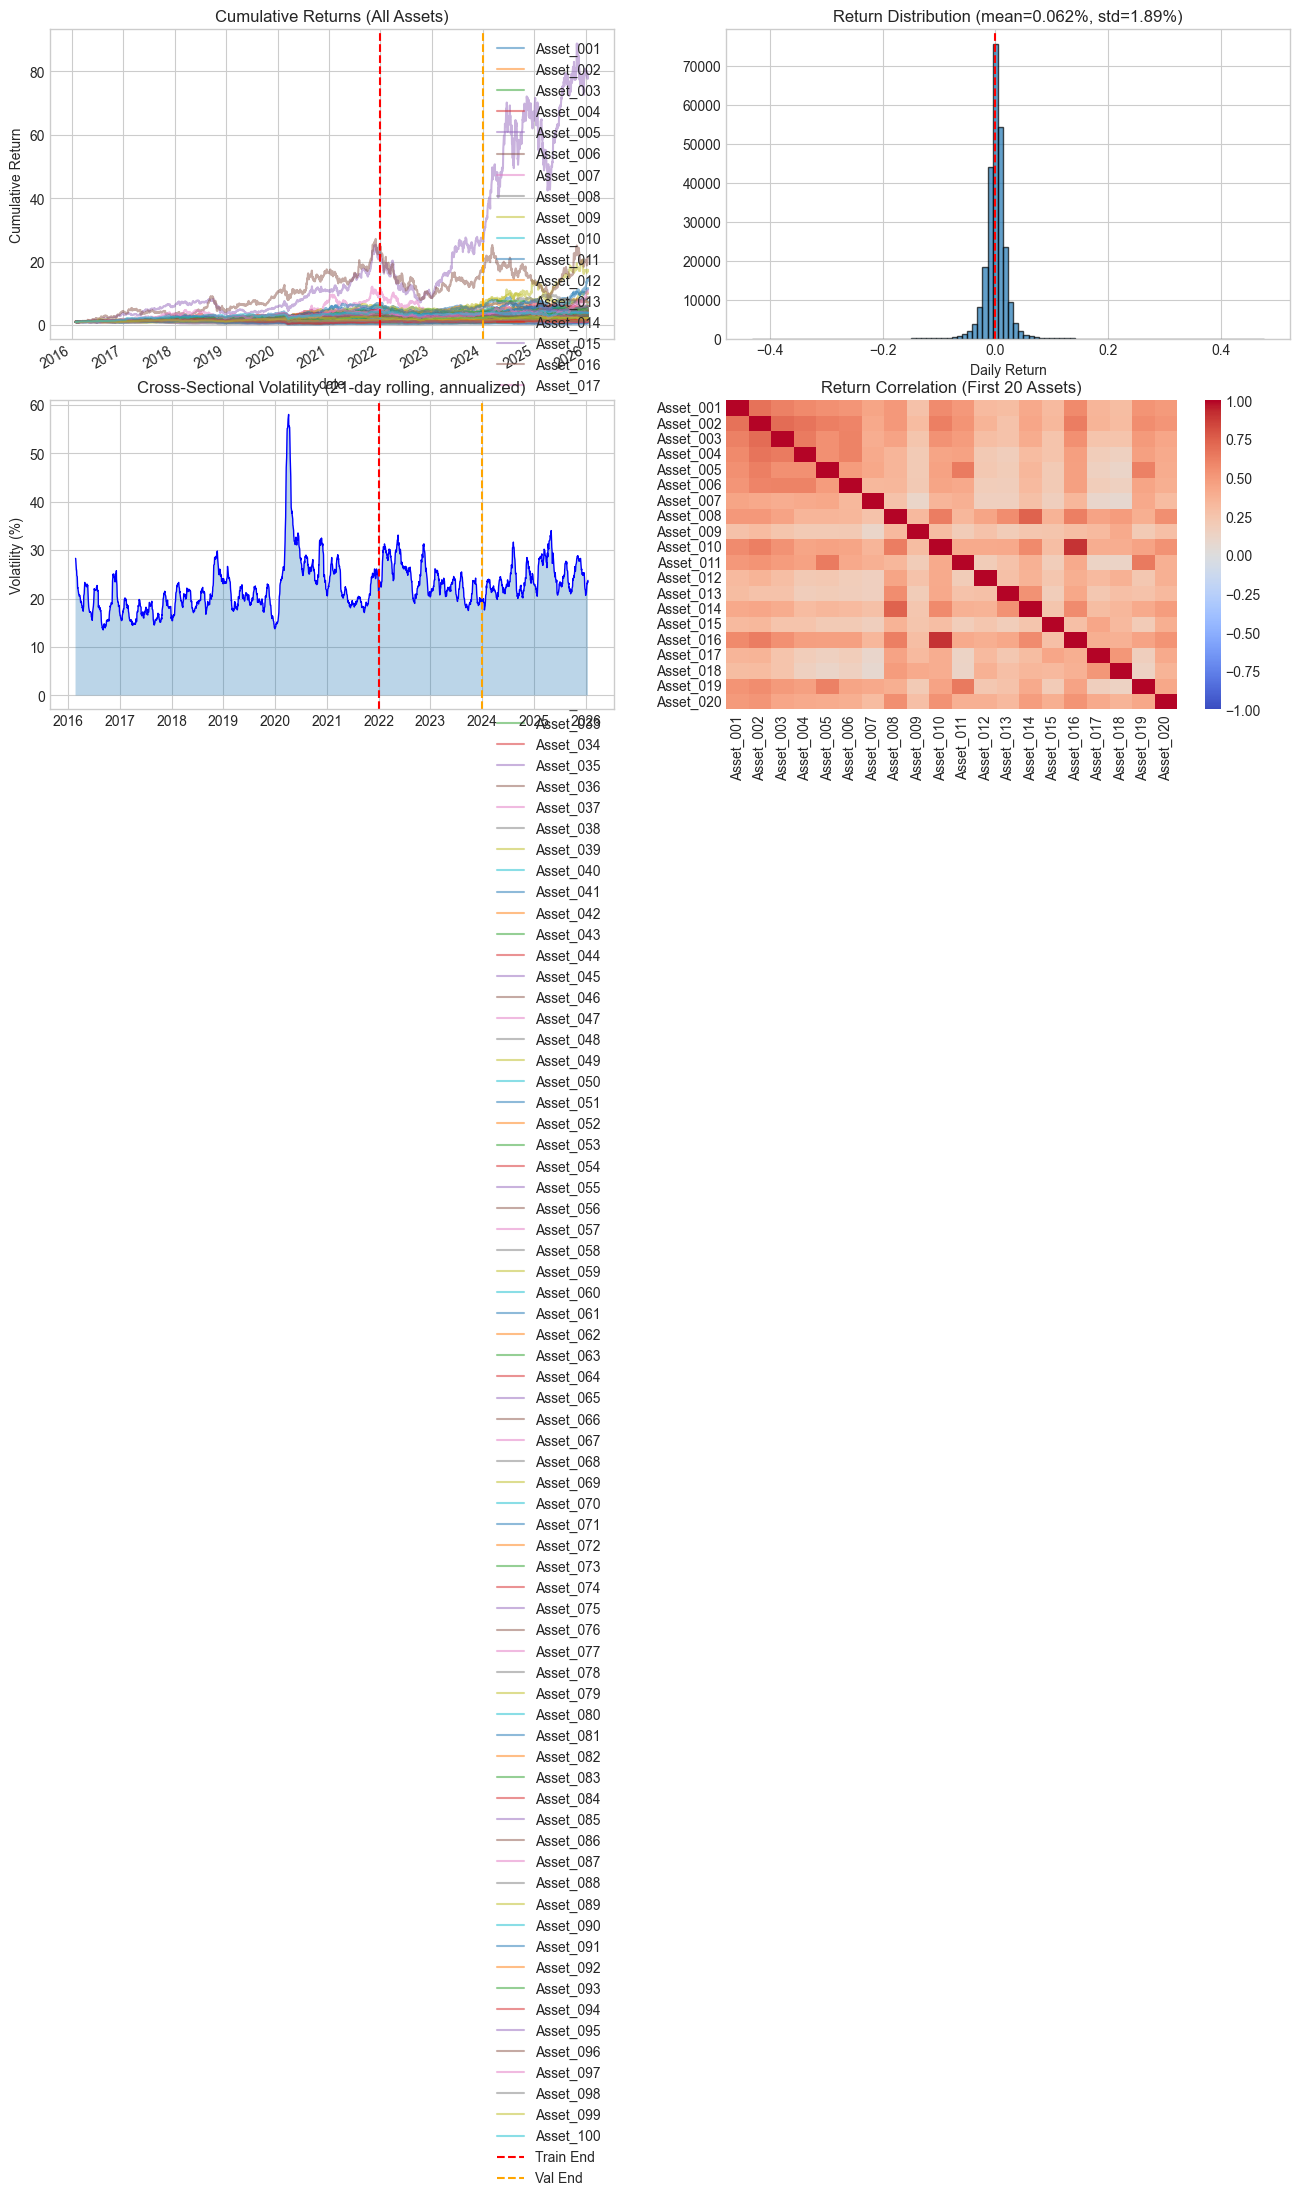

In [4]:
# =============================================================================
# VISUALIZE DATA
# =============================================================================

returns = loader.panel['returns']
close = loader.panel['close']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Cumulative returns of all assets
ax = axes[0, 0]
cum_returns = (1 + returns).cumprod()
cum_returns.plot(ax=ax, alpha=0.5, legend=False)
ax.set_title('Cumulative Returns (All Assets)')
ax.set_ylabel('Cumulative Return')
ax.axvline(pd.Timestamp(config.train_end), color='red', linestyle='--', label='Train End')
ax.axvline(pd.Timestamp(config.val_end), color='orange', linestyle='--', label='Val End')
ax.legend()

# 2. Return distribution
ax = axes[0, 1]
returns_flat = returns.values.flatten()
returns_flat = returns_flat[~np.isnan(returns_flat)]
ax.hist(returns_flat, bins=100, alpha=0.7, edgecolor='black')
ax.set_title(f'Return Distribution (mean={np.mean(returns_flat)*100:.3f}%, std={np.std(returns_flat)*100:.2f}%)')
ax.set_xlabel('Daily Return')
ax.axvline(0, color='red', linestyle='--')

# 3. Rolling volatility
ax = axes[1, 0]
vol = returns.std(axis=1).rolling(21).mean() * np.sqrt(252) * 100
ax.plot(vol.index, vol.values, 'b-', linewidth=1)
ax.fill_between(vol.index, 0, vol.values, alpha=0.3)
ax.set_title('Cross-Sectional Volatility (21-day rolling, annualized)')
ax.set_ylabel('Volatility (%)')
ax.axvline(pd.Timestamp(config.train_end), color='red', linestyle='--')
ax.axvline(pd.Timestamp(config.val_end), color='orange', linestyle='--')

# 4. Correlation heatmap (sample)
ax = axes[1, 1]
sample_assets = returns.columns[:20]
corr = returns[sample_assets].corr()
sns.heatmap(corr, ax=ax, cmap='coolwarm', center=0, vmin=-1, vmax=1)
ax.set_title('Return Correlation (First 20 Assets)')

plt.tight_layout()
plt.savefig('../outputs/data_overview.png', dpi=150, bbox_inches='tight')
plt.show()

In [5]:
# =============================================================================
# PER-ASSET SUMMARY
# =============================================================================

summary = loader.summary()
print("\n📈 Asset Summary Statistics:")
print(summary.describe().round(2))

# Best and worst performers
print("\n🏆 Best Sharpe Assets:")
print(summary.nlargest(5, 'sharpe')[['ann_return', 'ann_vol', 'sharpe']].round(2))

print("\n📉 Worst Sharpe Assets:")
print(summary.nsmallest(5, 'sharpe')[['ann_return', 'ann_vol', 'sharpe']].round(2))


📈 Asset Summary Statistics:
       n_days  ann_return  ann_vol  sharpe  max_dd  nan_pct
count   100.0      100.00   100.00  100.00  100.00   100.00
mean   2510.0       15.64    29.01    0.53  -50.99     0.04
std       0.0        8.93     7.63    0.22   14.48     0.00
min    2510.0       -0.19    18.16   -0.00  -87.61     0.04
25%    2510.0       10.92    23.97    0.40  -60.27     0.04
50%    2510.0       14.51    27.34    0.56  -47.68     0.04
75%    2510.0       19.24    32.10    0.66  -41.36     0.04
max    2510.0       56.16    59.12    1.13  -25.59     0.04

🏆 Best Sharpe Assets:
           ann_return  ann_vol  sharpe
asset                                 
Asset_005       56.16    49.52    1.13
Asset_019       36.24    38.85    0.93
Asset_009       27.25    29.32    0.93
Asset_024       20.36    21.96    0.93
Asset_088       22.40    24.32    0.92

📉 Worst Sharpe Assets:
           ann_return  ann_vol  sharpe
asset                                 
Asset_091       -0.19    40.52   

---

# Part 2: Feature Engineering

Generate a comprehensive set of features across 5 categories:
1. **Momentum**: Trend-following signals
2. **Volatility**: Risk regime indicators  
3. **Mean Reversion**: Counter-trend signals
4. **Statistical Arbitrage**: Cross-sectional relationships
5. **Technical**: Classic indicators

**Goal**: Create diverse, uncorrelated features that capture different market dynamics.

In [6]:
# =============================================================================
# COMPUTE ALL FEATURES
# =============================================================================

# Use train + validation data for feature engineering
# (We'll use test data ONLY for final holdout evaluation)
train_val_data = loader.get_split('train_val')

returns = train_val_data['returns']
close = train_val_data['close']
high = train_val_data['high']
low = train_val_data['low']
open_ = train_val_data['open']
volume = train_val_data['volume']

print(f"Feature engineering on {len(returns)} days ({returns.index[0].strftime('%Y-%m-%d')} to {returns.index[-1].strftime('%Y-%m-%d')})")

# Initialize feature store
feature_config = FeatureConfig(
    compute_momentum=True,
    compute_volatility=True,
    compute_mean_reversion=True,
    compute_stat_arb=True,
    compute_technical=True,
    standardize=True,
    standardize_method='zscore',
    winsorize_pct=0.01,
    max_nan_pct=0.15,
)

feature_store = FeatureStore(feature_config)

# Compute all features
features = feature_store.compute_all_features(
    returns=returns,
    close=close,
    high=high,
    low=low,
    open_=open_,
    volume=volume,
    verbose=True
)

Feature engineering on 1998 days (2016-01-25 to 2023-12-29)
COMPUTING ALL FEATURES
Computing momentum features...
✅ Created 19 momentum features
Computing volatility features...


✅ Created 23 volatility features
Computing mean reversion features...
✅ Created 25 mean reversion features
Computing statistical arbitrage features...
✅ Created 17 stat arb features
Computing technical features...
✅ Created 24 technical features

📊 Total raw features: 108

Cleaning and standardizing features...
✅ Kept 108 features, removed 0


In [7]:
# =============================================================================
# FEATURE SUMMARY BY CATEGORY
# =============================================================================

summary = feature_store.summary()
category_counts = summary.groupby('category').size()








print("\n📊 Features by Category:")
print(category_counts)
print(f"\n📦 Total Features: {len(features)}")

# List all features
print("\n📋 Feature List:")
for cat in category_counts.index:
    cat_features = summary[summary['category'] == cat].index.tolist()
    print(f"\n{cat.upper()} ({len(cat_features)} features):")
    for i, f in enumerate(cat_features, 1):
        print(f"   {i:2d}. {f}")


📊 Features by Category:
category
mean_reversion    19
momentum          24
other             16
stat_arb           7
technical         17
volatility        25
dtype: int64

📦 Total Features: 108

📋 Feature List:

MEAN_REVERSION (19 features):
    1. zscore_10d
    2. zscore_21d
    3. zscore_42d
    4. zscore_63d
    5. rsi_7d
    6. rsi_14d
    7. rsi_21d
    8. bb_pos_20d
    9. bb_width_20d
   10. bb_pos_40d
   11. bb_width_40d
   12. reversal_1d
   13. reversal_5d
   14. extreme_reversal
   15. stoch_k_14d
   16. stoch_d_14d
   17. stoch_k_21d
   18. stoch_d_21d
   19. dispersion_zscore

MOMENTUM (24 features):
    1. ret_5d
    2. ret_10d
    3. ret_21d
    4. ret_42d
    5. ret_63d
    6. mom_5_21
    7. mom_5_63
    8. mom_21_63
    9. mom_12_1
   10. accel_5d
   11. accel_21d
   12. mom_accel
   13. streak_sign
   14. tsmom
   15. tsmom_short
   16. mom_quality_21d
   17. mom_ir_21d
   18. ret_deviation_252d
   19. cs_rank_ret_5d
   20. cs_rank_ret_21d
   21. cs_rank_ret_63d
 

---

# Part 3: Feature Analysis

Analyze features to:
1. **Correlation Analysis**: Find redundant features
2. **Information Coefficient (IC)**: Measure predictive power
3. **Feature Selection**: Keep only useful, uncorrelated features

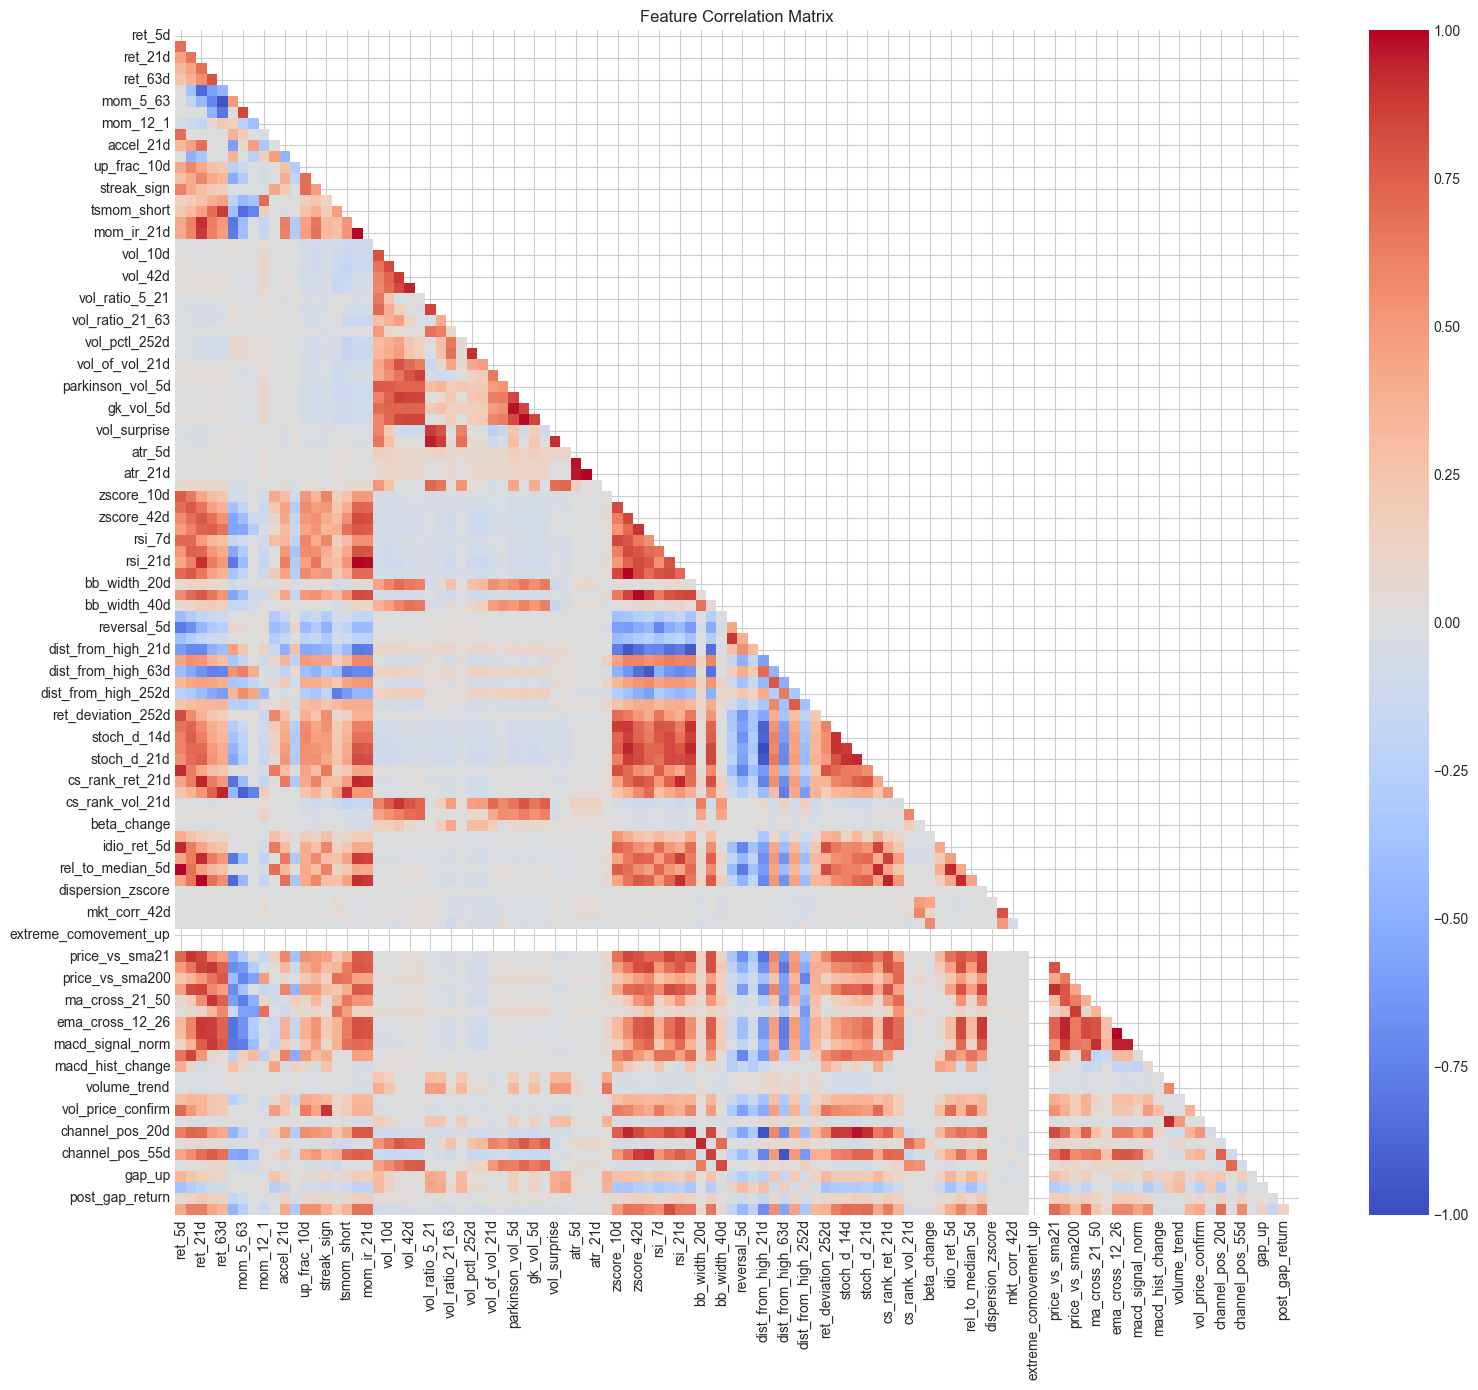


⚠️ Highly correlated feature pairs (|corr| > 0.8): 206
   ret_5d <-> rel_to_median_5d: 1.000
   ret_21d <-> rel_to_median_21d: 1.000
   dist_from_high_21d <-> stoch_k_21d: -1.000
   mom_quality_21d <-> rsi_21d: 1.000
   ema_cross_12_26 <-> macd_norm: 0.998
   zscore_21d <-> bb_pos_20d: 0.996
   zscore_42d <-> bb_pos_40d: 0.995
   atr_14d <-> atr_21d: 0.994
   mom_quality_21d <-> mom_ir_21d: 0.990
   parkinson_vol_21d <-> gk_vol_21d: 0.990


In [8]:
# =============================================================================
# FEATURE CORRELATION ANALYSIS
# =============================================================================

# Compute feature correlations
corr_matrix = feature_store.analyze_correlations()

# Plot heatmap
fig, ax = plt.subplots(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0, 
            ax=ax, vmin=-1, vmax=1, annot=False)
ax.set_title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('../outputs/feature_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

print(f"\n⚠️ Highly correlated feature pairs (|corr| > 0.8): {len(high_corr_pairs)}")
for f1, f2, c in sorted(high_corr_pairs, key=lambda x: -abs(x[2]))[:10]:
    print(f"   {f1} <-> {f2}: {c:.3f}")


📊 Top Features by IC IR (Information Ratio):
                         category  mean_ic  std_ic   ic_ir  pct_positive  \
feature                                                                    
mom_12_1                 momentum   0.0185  0.2735  0.0675        0.5290   
ma_cross_50_200         technical   0.0185  0.2774  0.0666        0.5275   
tsmom                    momentum   0.0153  0.2437  0.0629        0.5340   
reversal_1d        mean_reversion   0.0125  0.2204  0.0569        0.5175   
vol_of_vol_21d         volatility   0.0112  0.2076  0.0538        0.5285   
vol_of_vol_63d         volatility   0.0129  0.2401  0.0537        0.5305   
price_vs_sma200             other   0.0142  0.2730  0.0520        0.5375   
channel_width_55d       technical   0.0138  0.2710  0.0510        0.5185   
vol_42d                volatility   0.0148  0.2954  0.0500        0.5145   
parkinson_vol_21d      volatility   0.0142  0.2899  0.0491        0.5250   
gk_vol_5d              volatility   0.0132

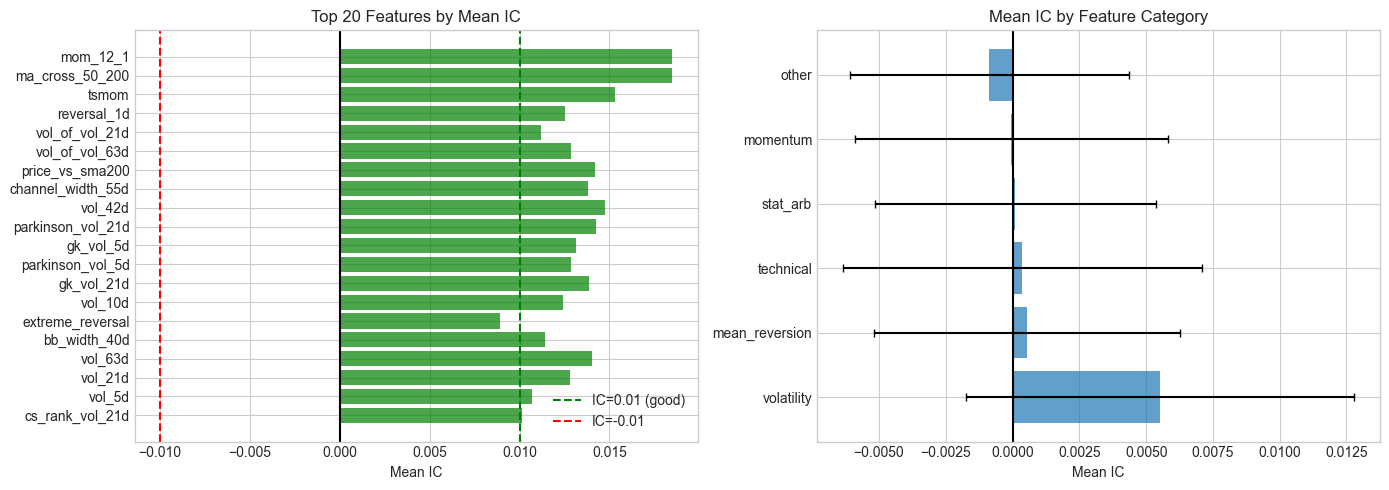

In [9]:
# =============================================================================
# INFORMATION COEFFICIENT (IC) ANALYSIS
# =============================================================================

# Forward returns for IC calculation
fwd_returns_1d = returns.shift(-1)

# Compute IC for each feature
ic_analysis = feature_store.compute_feature_ic(fwd_returns_1d, horizon=1)

print("\n📊 Top Features by IC IR (Information Ratio):")
print(ic_analysis.head(20).round(4))

# Plot IC distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# IC by feature
ax = axes[0]
top_20 = ic_analysis.head(20)
colors = ['green' if x > 0 else 'red' for x in top_20['mean_ic']]
ax.barh(range(len(top_20)), top_20['mean_ic'], color=colors, alpha=0.7)
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20.index)
ax.axvline(0, color='black', linestyle='-')
ax.axvline(0.01, color='green', linestyle='--', label='IC=0.01 (good)')
ax.axvline(-0.01, color='red', linestyle='--', label='IC=-0.01')
ax.set_xlabel('Mean IC')
ax.set_title('Top 20 Features by Mean IC')
ax.legend()
ax.invert_yaxis()

# IC by category
ax = axes[1]
ic_by_cat = ic_analysis.groupby('category')['mean_ic'].agg(['mean', 'std', 'count'])
ic_by_cat = ic_by_cat.sort_values('mean', ascending=False)
ax.barh(ic_by_cat.index, ic_by_cat['mean'], xerr=ic_by_cat['std'], alpha=0.7, capsize=3)
ax.axvline(0, color='black', linestyle='-')
ax.set_xlabel('Mean IC')
ax.set_title('Mean IC by Feature Category')

plt.tight_layout()
plt.savefig('../outputs/feature_ic_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [10]:
# =============================================================================
# FEATURE SELECTION
# =============================================================================

# Select features based on:
# 1. IC significance (t-stat > 2 or < -2)
# 2. Remove highly correlated duplicates (keep higher IC)

# Step 1: Filter by IC significance
ic_threshold = 1.96  # ~95% confidence
significant_features = ic_analysis[abs(ic_analysis['t_stat']) > ic_threshold].index.tolist()
print(f"Significant features (|t-stat| > {ic_threshold}): {len(significant_features)}")

# Step 2: Remove highly correlated features (keep the one with higher |IC|)
def remove_correlated_features(features, corr_matrix, ic_values, threshold=0.8):
    """Remove highly correlated features, keeping higher IC ones."""
    features = list(features)
    to_remove = set()
    
    for i in range(len(features)):
        if features[i] in to_remove:
            continue
        for j in range(i+1, len(features)):
            if features[j] in to_remove:
                continue
            if abs(corr_matrix.loc[features[i], features[j]]) > threshold:
                # Remove the one with lower |IC|
                ic_i = abs(ic_values.get(features[i], 0))
                ic_j = abs(ic_values.get(features[j], 0))
                if ic_i < ic_j:
                    to_remove.add(features[i])
                else:
                    to_remove.add(features[j])
    
    return [f for f in features if f not in to_remove]

# Get IC values as dict
ic_values = ic_analysis['mean_ic'].to_dict()

# Apply to significant features
selected_features = remove_correlated_features(
    significant_features, 
    corr_matrix, 
    ic_values,
    threshold=0.85
)

print(f"\n✅ Selected features (after removing correlations): {len(selected_features)}")
print("\nSelected Features:")
for i, f in enumerate(selected_features, 1):
    cat = feature_store.feature_metadata.get(f, {}).get('category', 'unknown')
    ic = ic_values.get(f, 0)
    print(f"   {i:2d}. [{cat:15s}] {f:30s} IC={ic:+.4f}")

Significant features (|t-stat| > 1.96): 19

✅ Selected features (after removing correlations): 12

Selected Features:
    1. [momentum       ] mom_12_1                       IC=+0.0185
    2. [technical      ] ma_cross_50_200                IC=+0.0185
    3. [momentum       ] tsmom                          IC=+0.0153
    4. [mean_reversion ] reversal_1d                    IC=+0.0125
    5. [volatility     ] vol_of_vol_21d                 IC=+0.0112
    6. [technical      ] channel_width_55d              IC=+0.0138
    7. [volatility     ] vol_42d                        IC=+0.0148
    8. [volatility     ] gk_vol_5d                      IC=+0.0132
    9. [volatility     ] gk_vol_21d                     IC=+0.0138
   10. [volatility     ] vol_10d                        IC=+0.0124
   11. [mean_reversion ] bb_width_40d                   IC=+0.0114
   12. [volatility     ] vol_5d                         IC=+0.0107


In [11]:
# =============================================================================
# SAVE SELECTED FEATURES
# =============================================================================

import json

# Create selected features dict
selected_features_dict = {f: features[f] for f in selected_features if f in features}

# Save feature names
feature_selection_log = {
    'total_features': len(features),
    'significant_features': len(significant_features),
    'selected_features': len(selected_features),
    'feature_names': selected_features,
    'ic_stats': {f: {'mean_ic': float(ic_analysis.loc[f, 'mean_ic']),
                     'ic_ir': float(ic_analysis.loc[f, 'ic_ir']),
                     'category': feature_store.feature_metadata.get(f, {}).get('category', 'unknown')}
                 for f in selected_features if f in ic_analysis.index}
}

with open('../outputs/feature_selection.json', 'w') as f:
    json.dump(feature_selection_log, f, indent=2)

print(f"✅ Saved {len(selected_features)} selected features to outputs/feature_selection.json")

✅ Saved 12 selected features to outputs/feature_selection.json


---

# Part 4: LightGBM Experiments

Train LightGBM models with walk-forward validation to:
1. Test if we can extract an edge from features
2. Analyze feature importance
3. Evaluate accuracy and hit ratio

In [12]:
# =============================================================================
# SETUP MODEL TRAINING
# =============================================================================

from models.trainer import WalkForwardTrainer, ModelConfig, compute_hit_ratio
from backtest.backtester import Backtester, BacktestConfig, analyze_regime_performance, compute_win_loss_stats

# Model configuration
model_config = ModelConfig(
    model_type='lightgbm',
    training_window=504,       # 2 years
    retrain_interval=21,       # Monthly retrain
    label_type='3class',
    label_threshold=0.005,     # ±0.5%
    forward_horizon=1,         # 1-day forward
    use_sample_weights=True,
    decay_halflife=63,         # Quarterly decay
    lgbm_params={
        'objective': 'multiclass',
        'num_class': 3,
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'n_estimators': 100,
        'min_child_samples': 30,  # More regularization
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
    }
)

print("Model Configuration:")
print(f"   Training window: {model_config.training_window} days")
print(f"   Retrain interval: {model_config.retrain_interval} days")
print(f"   Label threshold: ±{model_config.label_threshold*100:.1f}%")
print(f"   Sample weight decay: {model_config.decay_halflife} days")

Model Configuration:
   Training window: 504 days
   Retrain interval: 21 days
   Label threshold: ±0.5%
   Sample weight decay: 63 days


In [13]:
# =============================================================================
# RUN WALK-FORWARD TRAINING (ON TRAIN DATA ONLY)
# =============================================================================

print("="*70)
print("WALK-FORWARD TRAINING (Train Period: 2016-2021)")
print("="*70)

# Use only training data
train_returns = loader.get_returns('train')

# Filter features to training period
train_features = {f: selected_features_dict[f].loc[train_returns.index[0]:train_returns.index[-1]] 
                  for f in selected_features_dict}

print(f"\nTraining on {len(train_returns)} days with {len(train_features)} features")

# Initialize trainer
trainer = WalkForwardTrainer(model_config)

# Run walk-forward
train_results = trainer.run_walk_forward(
    features=train_features,
    returns=train_returns,
    verbose=True
)

print(f"\n✅ Training complete. Retrained {len(train_results['retrain_dates'])} times.")

WALK-FORWARD TRAINING (Train Period: 2016-2021)

Training on 1497 days with 12 features
Building feature matrix: 1497 dates x 100 assets x 12 features
  Retrained at 2017-07-19, samples=37400, classes=(array([0, 1, 2]), array([ 9428, 15943, 12029]))
  Retrained at 2018-05-18, samples=50400, classes=(array([0, 1, 2]), array([12853, 21351, 16196]))
  Retrained at 2019-03-21, samples=50400, classes=(array([0, 1, 2]), array([14109, 19061, 17230]))
  Retrained at 2020-01-21, samples=50400, classes=(array([0, 1, 2]), array([15365, 16610, 18425]))
  Retrained at 2020-11-17, samples=50400, classes=(array([0, 1, 2]), array([16617, 14140, 19643]))
  Retrained at 2021-09-20, samples=50400, classes=(array([0, 1, 2]), array([16799, 14295, 19306]))

✅ Training complete. Retrained 54 times.



📊 Feature Importance (LightGBM):
feature
reversal_1d          892.018519
vol_5d               796.851852
gk_vol_5d            771.814815
channel_width_55d    759.296296
mom_12_1             744.629630
gk_vol_21d           728.259259
vol_10d              726.648148
tsmom                722.000000
ma_cross_50_200      719.833333
vol_of_vol_21d       716.666667
vol_42d              713.259259
bb_width_40d         708.722222
Name: importance, dtype: float64


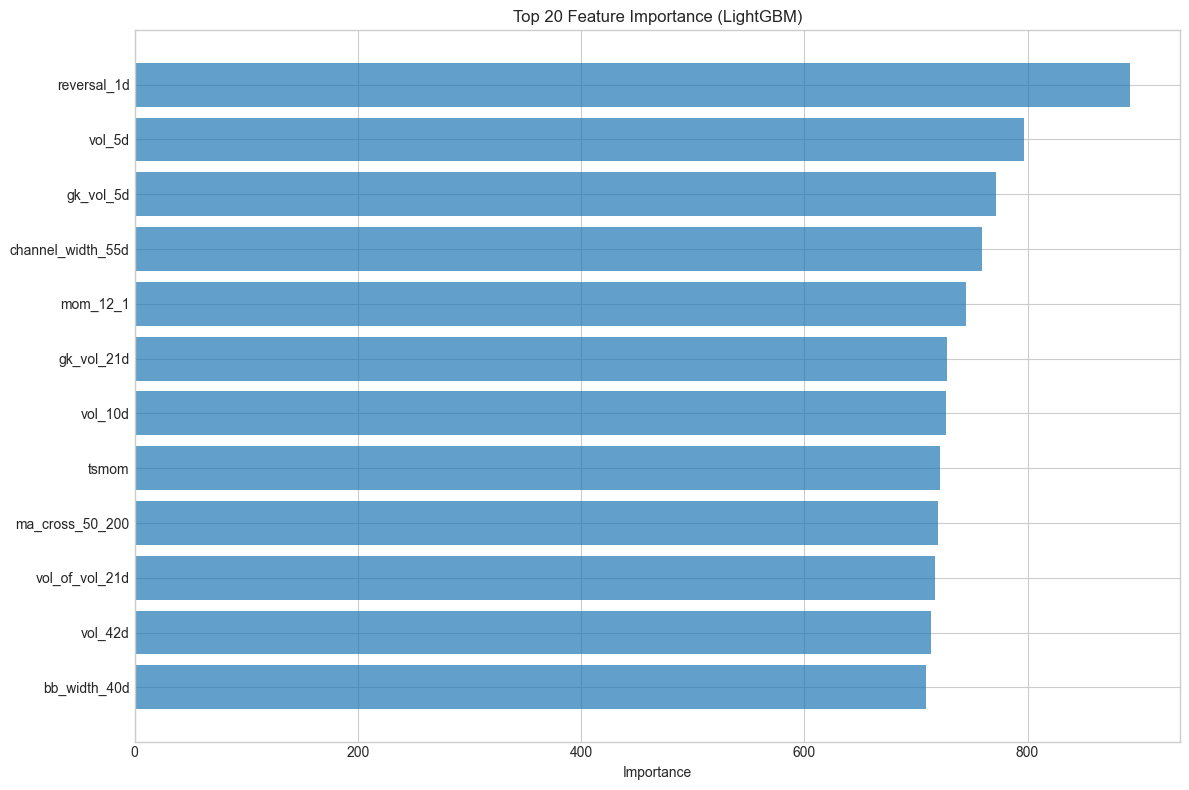

In [14]:
# =============================================================================
# FEATURE IMPORTANCE ANALYSIS
# =============================================================================

fi = train_results['feature_importance']

print("\n📊 Feature Importance (LightGBM):")
print(fi.head(20))


# Plot feature importance
fig, ax = plt.subplots(figsize=(12, 8))
top_fi = fi.head(20)
ax.barh(range(len(top_fi)), top_fi.values, alpha=0.7)
ax.set_yticks(range(len(top_fi)))
ax.set_yticklabels(top_fi.index)
ax.set_xlabel('Importance')
ax.set_title('Top 20 Feature Importance (LightGBM)')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('../outputs/lgbm_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

In [15]:
# =============================================================================
# COMPUTE ALPHA AND BACKTEST (TRAINING PERIOD)
# =============================================================================

# Compute hit ratios
hit_ratios = compute_hit_ratio(
    train_results['predictions'],
    train_results['labels'],
    window=63
)

# Compute alpha
alpha = trainer.compute_alpha(
    train_results['probs_up'],
    train_results['probs_down'],
    hit_ratios=hit_ratios
)

print(f"Alpha shape: {alpha.shape}")
print(f"Alpha mean: {alpha.mean().mean():.6f}")
print(f"Alpha std: {alpha.std().mean():.6f}")

# Run backtest
backtest_config = BacktestConfig(
    transaction_cost_bps=10,
    execution_lag=1,
)

backtester = Backtester(backtest_config)
train_backtest = backtester.run(alpha, train_returns)

print("\n📊 Training Period Metrics:")
for k, v in train_backtest['metrics'].items():
    if isinstance(v, float):
        print(f"   {k}: {v:.4f}")

Alpha shape: (1497, 100)
Alpha mean: 0.000000
Alpha std: 0.029519

📊 Training Period Metrics:
   gross_sharpe: 0.5929
   net_sharpe: -1.2818
   gross_ann_return: 0.0273
   net_ann_return: -0.0590
   gross_ann_vol: 0.0460
   net_ann_vol: 0.0460
   max_drawdown: -0.3091
   calmar: -0.1910
   avg_turnover: 0.3425
   ann_turnover: 86.3208
   total_return: -0.3002


In [16]:
# =============================================================================
# VALIDATION PERIOD TEST (OUT-OF-SAMPLE DURING DEVELOPMENT)
# =============================================================================
# 
# IMPORTANT: For validation, we need to CONTINUE the walk-forward from training,
# not start fresh. This means:
# 1. Use the SAME features computed on FULL train+val period
# 2. The walk-forward will naturally use training data to make predictions on validation

print("="*70)
print("VALIDATION PERIOD (2022-2023) - Out-of-Sample Check")
print("="*70)

# Get validation returns
val_returns = loader.get_returns('val')
print(f"\nValidation period: {len(val_returns)} days")

# For proper validation, we need to run walk-forward on the ENTIRE period
# but only evaluate on the validation portion

# Combine train + val for walk-forward
full_returns = pd.concat([train_returns, val_returns])
full_features = {f: selected_features_dict[f].loc[full_returns.index[0]:full_returns.index[-1]] 
                 for f in selected_features_dict}

print(f"Running walk-forward on full period: {len(full_returns)} days")

# Run walk-forward on full period (will train on train, predict on val)
from importlib import reload
import models.trainer as trainer_module
reload(trainer_module)
from models.trainer import WalkForwardTrainer, ModelConfig, compute_hit_ratio

trainer_full = WalkForwardTrainer(model_config)
full_results = trainer_full.run_walk_forward(
    features=full_features,
    returns=full_returns,
    verbose=True
)

# Extract validation period predictions
val_start = val_returns.index[0]
val_preds = full_results['predictions'].loc[val_start:]
val_probs_up = full_results['probs_up'].loc[val_start:]
val_probs_down = full_results['probs_down'].loc[val_start:]
val_labels = full_results['labels'].loc[val_start:]

print(f"\n✅ Validation predictions: {len(val_preds)} days")

# Compute alpha and backtest for validation period
val_hit_ratios = compute_hit_ratio(val_preds, val_labels, window=63)

val_alpha = trainer_full.compute_alpha(
    val_probs_up,
    val_probs_down,
    hit_ratios=val_hit_ratios
)

val_backtest = backtester.run(val_alpha, val_returns)

print("\n📊 Validation Period Metrics:")
for k, v in val_backtest['metrics'].items():
    if isinstance(v, float):
        print(f"   {k}: {v:.4f}")

VALIDATION PERIOD (2022-2023) - Out-of-Sample Check

Validation period: 501 days
Running walk-forward on full period: 1998 days
Building feature matrix: 1998 dates x 100 assets x 12 features
  Retrained at 2018-01-17, samples=49900, classes=(array([0, 1, 2]), array([12305, 21522, 16073]))
  Retrained at 2018-11-14, samples=50400, classes=(array([0, 1, 2]), array([13363, 20422, 16615]))
  Retrained at 2019-09-18, samples=50400, classes=(array([0, 1, 2]), array([14990, 17254, 18156]))
  Retrained at 2020-07-20, samples=50400, classes=(array([0, 1, 2]), array([16422, 14875, 19103]))
  Retrained at 2021-05-19, samples=50400, classes=(array([0, 1, 2]), array([16867, 13706, 19827]))
  Retrained at 2022-03-18, samples=50400, classes=(array([0, 1, 2]), array([16875, 13894, 19631]))
  Retrained at 2023-01-19, samples=50400, classes=(array([0, 1, 2]), array([17572, 14001, 18827]))
  Retrained at 2023-11-17, samples=50400, classes=(array([0, 1, 2]), array([17947, 13940, 18513]))

✅ Validation pre

In [17]:
# =============================================================================
# COMPARE TRAIN VS VALIDATION
# =============================================================================

comparison = pd.DataFrame({
    'Train (2016-2021)': train_backtest['metrics'],
    'Validation (2022-2023)': val_backtest['metrics']
}).round(4)

print("\n📊 Train vs Validation Comparison:")
print(comparison.to_string())

# Check for overfitting
train_sharpe = train_backtest['metrics']['net_sharpe']
val_sharpe = val_backtest['metrics']['net_sharpe']
decay = (train_sharpe - val_sharpe) / train_sharpe * 100 if train_sharpe != 0 else 0

print(f"\n🔍 Sharpe Decay: {decay:.1f}%")
if decay > 50:
    print("⚠️ WARNING: Significant overfitting detected!")
elif decay > 25:
    print("⚠️ Moderate decay - some overfitting possible")
else:
    print("✅ Good out-of-sample generalization")


📊 Train vs Validation Comparison:
                  Train (2016-2021)  Validation (2022-2023)
gross_sharpe                 0.5929                  1.2590
net_sharpe                  -1.2818                 -0.9512
gross_ann_return             0.0273                  0.0669
net_ann_return              -0.0590                 -0.0505
gross_ann_vol                0.0460                  0.0531
net_ann_vol                  0.0460                  0.0531
max_drawdown                -0.3091                 -0.1621
calmar                      -0.1910                 -0.3116
avg_turnover                 0.3425                  0.4660
ann_turnover                86.3208                117.4352
total_return                -0.3002                 -0.0981
n_days                    1497.0000                501.0000

🔍 Sharpe Decay: 25.8%
⚠️ Moderate decay - some overfitting possible


---

# Part 5: Regime Analysis & Failure Cases

Analyze where the model succeeds and fails:
- Bull vs Bear markets
- High vs Low volatility
- Win/Loss statistics


📊 Performance by Market Regime:
          sharpe  return  n_days  win_rate
bull     -1.8914 -0.0823   987.0    0.3465
bear      0.1206  0.0080   353.0    0.4589
sideways -1.2860 -0.0536   658.0    0.3526
high_vol -0.7165 -0.0438   807.0    0.4572
low_vol  -2.0650 -0.0852   919.0    0.3993


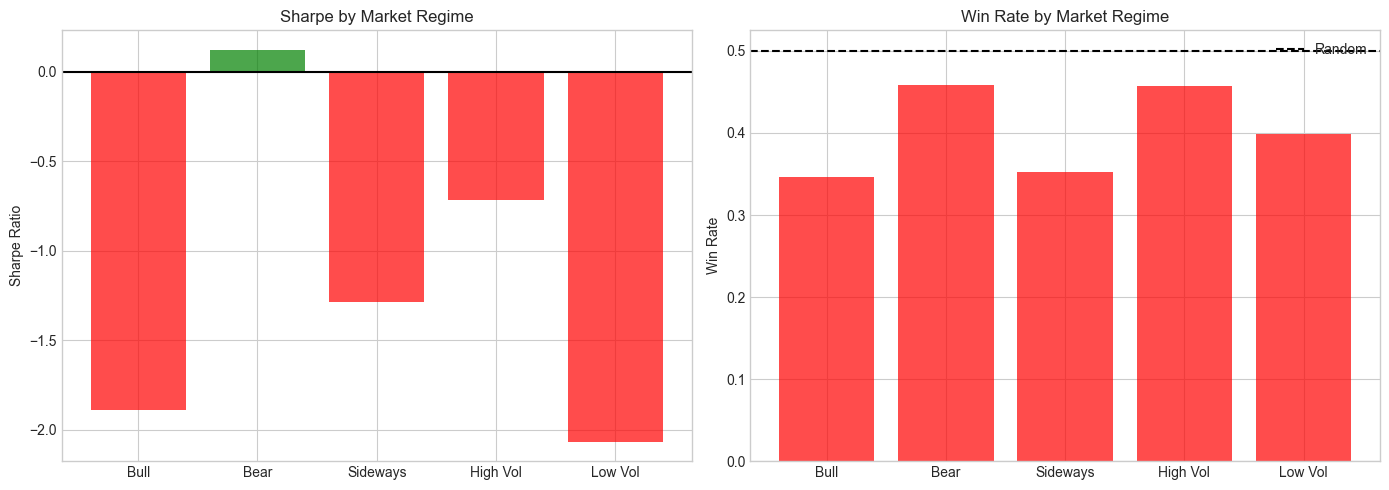

In [18]:
# =============================================================================
# REGIME PERFORMANCE ANALYSIS
# =============================================================================

# Combine train and val for analysis
combined_returns = pd.concat([train_backtest['net_returns'], val_backtest['net_returns']])
combined_market = loader.panel['returns'].mean(axis=1).loc[combined_returns.index]

regime_stats = analyze_regime_performance(combined_returns, combined_market)

print("\n📊 Performance by Market Regime:")
regime_df = pd.DataFrame(regime_stats).T
print(regime_df.round(4))

# Plot regime performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sharpe by regime
ax = axes[0]
sharpes = [regime_stats[r]['sharpe'] for r in ['bull', 'bear', 'sideways', 'high_vol', 'low_vol']]
colors = ['green' if s > 0 else 'red' for s in sharpes]
ax.bar(['Bull', 'Bear', 'Sideways', 'High Vol', 'Low Vol'], sharpes, color=colors, alpha=0.7)
ax.axhline(0, color='black', linestyle='-')
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Sharpe by Market Regime')

# Win rate by regime
ax = axes[1]
win_rates = [regime_stats[r].get('win_rate', 0.5) for r in ['bull', 'bear', 'sideways', 'high_vol', 'low_vol']]
colors = ['green' if w > 0.5 else 'red' for w in win_rates]
ax.bar(['Bull', 'Bear', 'Sideways', 'High Vol', 'Low Vol'], win_rates, color=colors, alpha=0.7)
ax.axhline(0.5, color='black', linestyle='--', label='Random')
ax.set_ylabel('Win Rate')
ax.set_title('Win Rate by Market Regime')
ax.legend()

plt.tight_layout()
plt.savefig('../outputs/regime_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [19]:
# =============================================================================
# WIN/LOSS ANALYSIS
# =============================================================================

win_loss = compute_win_loss_stats(combined_returns)

print("\n📊 Win/Loss Statistics:")
for k, v in win_loss.items():
    if isinstance(v, float):
        print(f"   {k}: {v:.4f}")
    else:
        print(f"   {k}: {v}")


📊 Win/Loss Statistics:
   win_rate: 0.3684
   avg_win: 0.0023
   avg_loss: -0.0024
   win_loss_ratio: 0.9510
   profit_factor: 0.7900
   max_consecutive_wins: 10
   max_consecutive_losses: 12
   best_day: 0.0208
   worst_day: -0.0191
   skewness: 0.1921
   kurtosis: 6.5080


In [20]:
# =============================================================================
# IDENTIFY FAILURE CASES
# =============================================================================

# Worst days
worst_days = combined_returns.nsmallest(20)
print("\n📉 Worst 20 Days:")
for date, ret in worst_days.items():
    mkt_ret = combined_market.loc[date] * 100
    print(f"   {date.strftime('%Y-%m-%d')}: {ret*100:+.2f}% (Market: {mkt_ret:+.2f}%)")

# Worst months
monthly_returns = combined_returns.resample('M').sum()
worst_months = monthly_returns.nsmallest(10)
print("\n📉 Worst 10 Months:")
for date, ret in worst_months.items():
    print(f"   {date.strftime('%Y-%m')}: {ret*100:+.2f}%")


📉 Worst 20 Days:
   2020-11-09: -1.91% (Market: +2.39%)
   2020-03-09: -1.77% (Market: -8.30%)
   2020-03-16: -1.48% (Market: -13.18%)
   2023-02-02: -1.25% (Market: +0.55%)
   2020-04-29: -1.24% (Market: +2.29%)
   2020-03-18: -1.19% (Market: -6.21%)
   2020-03-23: -1.16% (Market: -3.11%)
   2022-06-02: -1.13% (Market: +1.84%)
   2022-11-10: -1.12% (Market: +4.86%)
   2022-06-15: -1.10% (Market: +1.32%)
   2021-03-10: -1.07% (Market: +0.62%)
   2020-05-18: -1.07% (Market: +3.55%)
   2020-05-27: -1.06% (Market: +2.00%)
   2020-06-12: -1.03% (Market: +1.43%)
   2022-01-21: -1.01% (Market: -1.62%)
   2021-11-08: -1.00% (Market: +0.34%)
   2020-09-03: -0.99% (Market: -2.99%)
   2020-11-10: -0.94% (Market: +0.29%)
   2023-03-02: -0.92% (Market: +0.79%)
   2020-08-24: -0.90% (Market: +0.98%)

📉 Worst 10 Months:
   2021-04: -3.45%
   2018-05: -2.55%
   2021-09: -2.39%
   2023-02: -2.38%
   2019-06: -2.27%
   2019-09: -2.21%
   2023-01: -2.17%
   2021-06: -2.05%
   2018-06: -2.05%
   2021-08

In [21]:
# =============================================================================
# DRAWDOWN ANALYSIS
# =============================================================================

# Compute drawdowns
cum_returns = (1 + combined_returns).cumprod()
peak = cum_returns.cummax()
drawdown = (cum_returns - peak) / peak

# Find drawdown periods
def find_drawdown_periods(drawdown, threshold=-0.05):
    """Find periods where drawdown exceeds threshold."""
    in_dd = drawdown < threshold
    dd_starts = in_dd & ~in_dd.shift(1).fillna(False)
    dd_ends = ~in_dd & in_dd.shift(1).fillna(False)
    
    periods = []
    start = None
    for date in drawdown.index:
        if dd_starts.get(date, False):
            start = date
        if dd_ends.get(date, False) and start is not None:
            max_dd = drawdown.loc[start:date].min()
            periods.append((start, date, max_dd))
            start = None
    return periods

dd_periods = find_drawdown_periods(drawdown, -0.03)
print(f"\n📉 Drawdown Periods (> 3%):")
for start, end, dd in sorted(dd_periods, key=lambda x: x[2])[:10]:
    duration = (end - start).days
    print(f"   {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')} ({duration} days): {dd*100:.1f}%")


📉 Drawdown Periods (> 3%):
   2017-12-20 to 2017-12-27 (7 days): -3.3%


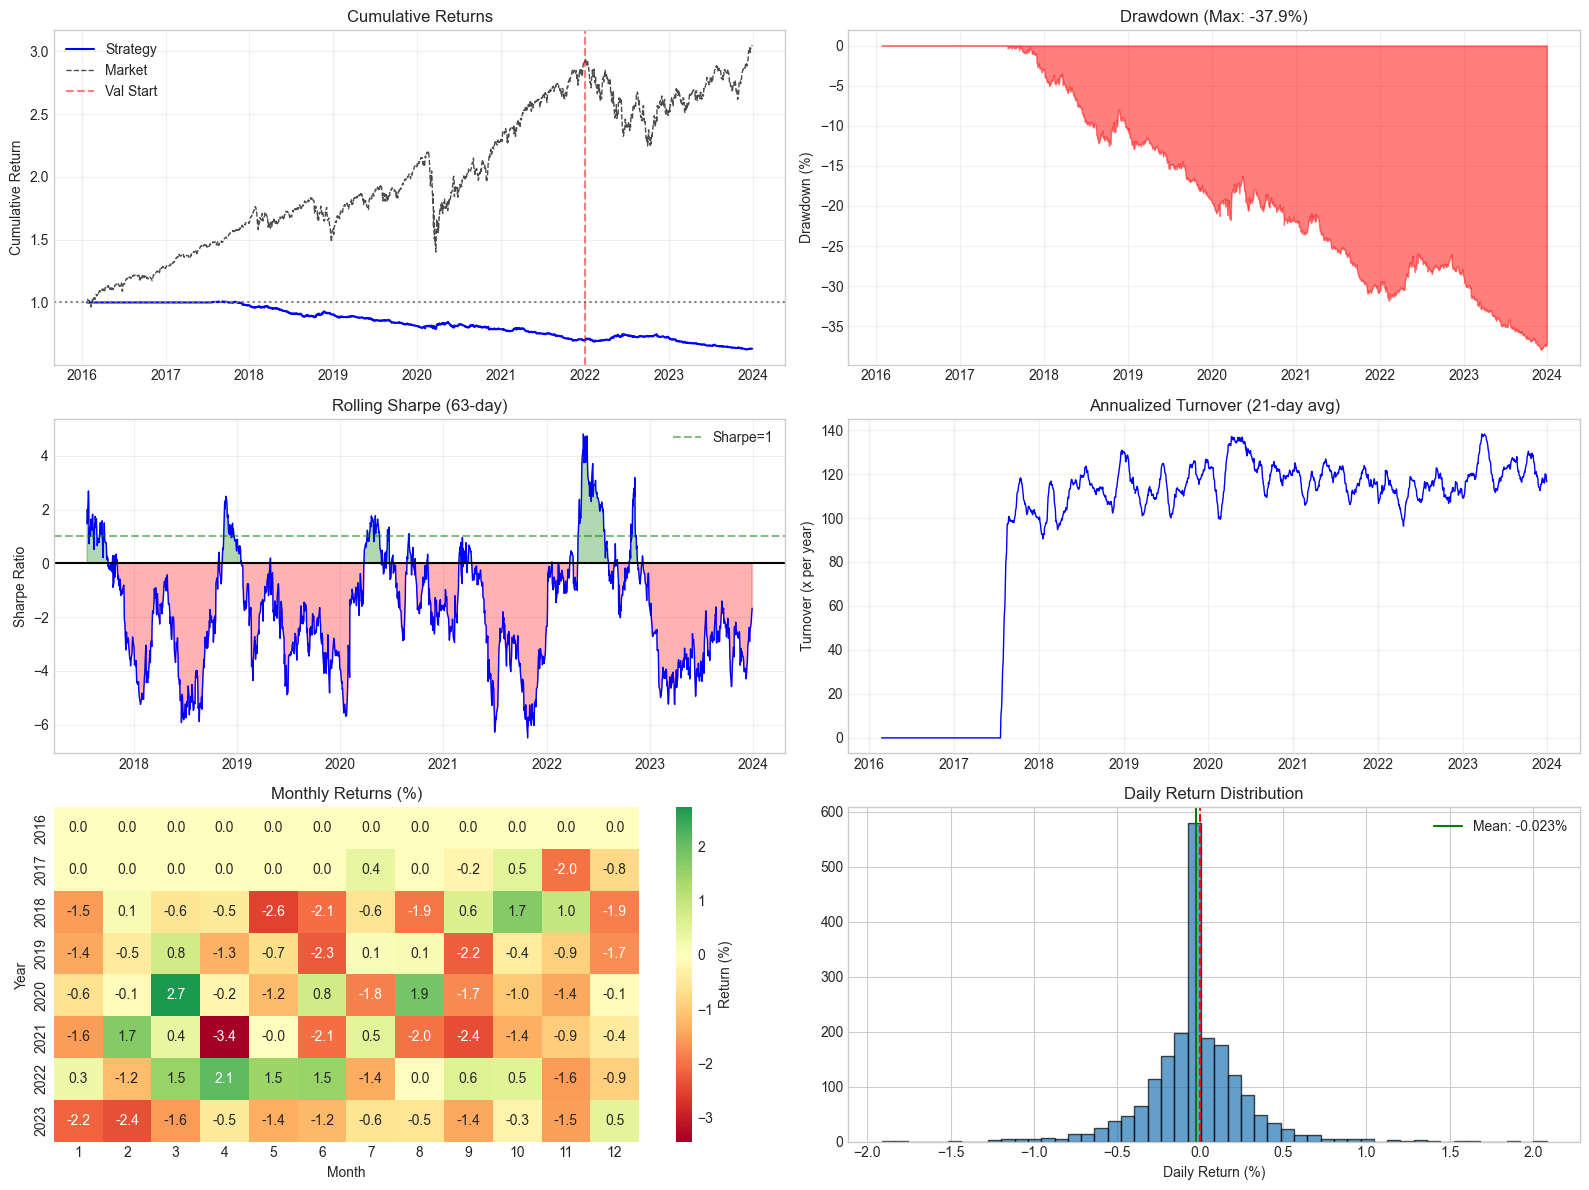

In [22]:
# =============================================================================
# COMPREHENSIVE VISUALIZATION
# =============================================================================

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# 1. Cumulative returns
ax = axes[0, 0]
cum = (1 + combined_returns).cumprod()
ax.plot(cum.index, cum.values, 'b-', linewidth=1.5, label='Strategy')
mkt_cum = (1 + combined_market).cumprod()
ax.plot(mkt_cum.index, mkt_cum.values, 'k--', linewidth=1, label='Market', alpha=0.7)
ax.axhline(1, color='gray', linestyle=':')
ax.axvline(pd.Timestamp('2022-01-01'), color='red', linestyle='--', alpha=0.5, label='Val Start')
ax.set_title('Cumulative Returns')
ax.set_ylabel('Cumulative Return')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Drawdown
ax = axes[0, 1]
ax.fill_between(drawdown.index, drawdown.values * 100, 0, color='red', alpha=0.5)
ax.set_title(f'Drawdown (Max: {drawdown.min()*100:.1f}%)')
ax.set_ylabel('Drawdown (%)')
ax.grid(True, alpha=0.3)

# 3. Rolling Sharpe
ax = axes[1, 0]
rolling_sharpe = combined_returns.rolling(63).mean() / combined_returns.rolling(63).std() * np.sqrt(252)
ax.plot(rolling_sharpe.index, rolling_sharpe.values, 'b-', linewidth=1)
ax.axhline(0, color='black', linestyle='-')
ax.axhline(1, color='green', linestyle='--', alpha=0.5, label='Sharpe=1')
ax.fill_between(rolling_sharpe.index, 0, rolling_sharpe.values, 
                where=rolling_sharpe.values > 0, color='green', alpha=0.3)
ax.fill_between(rolling_sharpe.index, 0, rolling_sharpe.values, 
                where=rolling_sharpe.values < 0, color='red', alpha=0.3)
ax.set_title('Rolling Sharpe (63-day)')
ax.set_ylabel('Sharpe Ratio')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Turnover
ax = axes[1, 1]
combined_turnover = pd.concat([train_backtest['turnover'], val_backtest['turnover']])
ax.plot(combined_turnover.index, combined_turnover.rolling(21).mean().values * 252, 'b-', linewidth=1)
ax.set_title(f'Annualized Turnover (21-day avg)')
ax.set_ylabel('Turnover (x per year)')
ax.grid(True, alpha=0.3)

# 5. Monthly returns heatmap
ax = axes[2, 0]
monthly = combined_returns.resample('M').sum() * 100
monthly_df = pd.DataFrame({
    'Year': monthly.index.year,
    'Month': monthly.index.month,
    'Return': monthly.values
})
monthly_pivot = monthly_df.pivot(index='Year', columns='Month', values='Return')
sns.heatmap(monthly_pivot, annot=True, fmt='.1f', cmap='RdYlGn', center=0, ax=ax,
            cbar_kws={'label': 'Return (%)'})
ax.set_title('Monthly Returns (%)')

# 6. Return distribution
ax = axes[2, 1]
ax.hist(combined_returns.values * 100, bins=50, alpha=0.7, edgecolor='black')
ax.axvline(0, color='red', linestyle='--')
ax.axvline(combined_returns.mean() * 100, color='green', linestyle='-', label=f'Mean: {combined_returns.mean()*100:.3f}%')
ax.set_title('Daily Return Distribution')
ax.set_xlabel('Daily Return (%)')
ax.legend()

plt.tight_layout()
plt.savefig('../outputs/comprehensive_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

---

# Part 6: Save Best Model & Results

Save the model configuration and results for reproducibility.

In [23]:
# =============================================================================
# SAVE EXPERIMENT RESULTS
# =============================================================================

import json
from datetime import datetime

experiment_log = {
    'timestamp': datetime.now().isoformat(),
    'model_type': 'LightGBM',
    'config': {
        'training_window': model_config.training_window,
        'retrain_interval': model_config.retrain_interval,
        'label_threshold': model_config.label_threshold,
        'decay_halflife': model_config.decay_halflife,
        'lgbm_params': model_config.lgbm_params,
    },
    'features': {
        'n_features': len(selected_features),
        'feature_names': selected_features,
    },
    'train_metrics': {k: float(v) if isinstance(v, (int, float, np.floating)) else v 
                      for k, v in train_backtest['metrics'].items()},
    'val_metrics': {k: float(v) if isinstance(v, (int, float, np.floating)) else v 
                    for k, v in val_backtest['metrics'].items()},
    'regime_stats': {k: {kk: float(vv) if isinstance(vv, (int, float, np.floating)) else vv 
                         for kk, vv in v.items()} 
                     for k, v in regime_stats.items()},
    'win_loss_stats': {k: float(v) if isinstance(v, (int, float, np.floating)) else v 
                       for k, v in win_loss.items()},
    'feature_importance': fi.head(20).to_dict(),
}

# Save
with open('../outputs/best_model_experiment.json', 'w') as f:
    json.dump(experiment_log, f, indent=2, default=str)

print("✅ Saved experiment results to outputs/best_model_experiment.json")

✅ Saved experiment results to outputs/best_model_experiment.json


In [24]:
# =============================================================================
# FINAL SUMMARY
# =============================================================================

print("="*70)
print("FINAL SUMMARY")
print("="*70)

print("\n📊 Key Metrics:")
print(f"   Training Period (2016-2021):")
print(f"      Net Sharpe: {train_backtest['metrics']['net_sharpe']:.4f}")
print(f"      Max Drawdown: {train_backtest['metrics']['max_drawdown']*100:.2f}%")
print(f"      Turnover: {train_backtest['metrics']['ann_turnover']:.0f}x/year")

print(f"\n   Validation Period (2022-2023):")
print(f"      Net Sharpe: {val_backtest['metrics']['net_sharpe']:.4f}")
print(f"      Max Drawdown: {val_backtest['metrics']['max_drawdown']*100:.2f}%")
print(f"      Turnover: {val_backtest['metrics']['ann_turnover']:.0f}x/year")

print(f"\n📈 Features Used: {len(selected_features)}")
print(f"   Top 5 by Importance:")
for i, (f, imp) in enumerate(fi.head(5).items(), 1):
    print(f"      {i}. {f}: {imp:.4f}")

print(f"\n🎯 Regime Performance:")
print(f"   Best: {max(regime_stats.keys(), key=lambda k: regime_stats[k]['sharpe'])}")
print(f"   Worst: {min(regime_stats.keys(), key=lambda k: regime_stats[k]['sharpe'])}")

print("\n" + "="*70)
print("⚠️ REMINDER: Holdout period (2024-2026) has NOT been touched.")
print("   Use it ONLY for final evaluation after all tuning is complete.")
print("="*70)

FINAL SUMMARY

📊 Key Metrics:
   Training Period (2016-2021):
      Net Sharpe: -1.2818
      Max Drawdown: -30.91%
      Turnover: 86x/year

   Validation Period (2022-2023):
      Net Sharpe: -0.9512
      Max Drawdown: -16.21%
      Turnover: 117x/year

📈 Features Used: 12
   Top 5 by Importance:
      1. reversal_1d: 892.0185
      2. vol_5d: 796.8519
      3. gk_vol_5d: 771.8148
      4. channel_width_55d: 759.2963
      5. mom_12_1: 744.6296

🎯 Regime Performance:
   Best: bear
   Worst: low_vol

⚠️ REMINDER: Holdout period (2024-2026) has NOT been touched.
   Use it ONLY for final evaluation after all tuning is complete.


---

# Next Steps

1. **If Sharpe > 0.5 on validation**: Proceed to holdout test
2. **If Sharpe < 0.5**: 
   - Try different feature combinations
   - Adjust model hyperparameters
   - Consider MLP or ensemble approaches

3. **Ensemble models**: Combine momentum + mean reversion signals for regime diversification
4. **Final holdout test**: Run once with frozen parameters